In [1]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from dotenv import load_dotenv
from supabase import create_client
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_community.tools.tavily_search import TavilySearchResults
import logging
import os
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

In [2]:
import supabase_service

Supabase client initialized: <supabase._sync.client.SyncClient object at 0x0000019C7F5A0710>


In [3]:
load_dotenv()
DB_CONNECTION = os.getenv("DB_CONNECTION")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_KEY")
TABLE_NAME = os.getenv("TABLE_NAME")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_TRACING_V2=os.getenv("LANGCHAIN_TRACING_V2")


In [4]:
chat = ChatOpenAI(model="gpt-4o", temperature=0)
# Crear cliente de Supabase
supabase = create_client(SUPABASE_URL, SUPABASE_KEY)
embeddings = OpenAIEmbeddings()  # Inicializar embeddings
vector_store = supabase_service.load_vector_store()
memory = SqliteSaver.from_conn_string(":memory:") #despues se conecta a bd

In [5]:
# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant tool."""

    datasource: Literal["informacion_general", "test_drive", "otro"] = Field(
        ...,
        description="Dado el input de un usuario, rutealo a información general, test drive u otro",
    )


In [6]:
#LLM with function call
chat = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_router = chat.with_structured_output(RouteQuery)

In [7]:
#Prompt
system = """Eres un chatbot del concesionario Parra Arango y eres experto en rutear el input de un usuario a informacion general o test drive
Informacion general contiene información sobre los vehiculos que maneja el concesionario, asi como repuestos y todo tipo de información que el publico necesita. Usa información general
para preguntas o inputs relacionados con eso. 
Test drive cuando el usuario quiera hacer test de un automovil.
Si el input del usuario no se relaciona con ninguna de las anteriores, usa otro
"""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

In [8]:
question_router=route_prompt | structured_llm_router

In [9]:
print(
    question_router.invoke(
        {"question": "Quiero probar el automovil ford mustang 2024"}
    )
)

datasource='test_drive'


In [10]:
print(
    question_router.invoke(
        {"question": "Cuantas puertas tiene el ford mustang"}
    )
)

datasource='informacion general'


In [11]:
print(
    question_router.invoke(
        {"question": "Quiero agendar cita para verme con un asesor"}
    )
)

datasource='otro'


In [9]:
### Retrieval Grader

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documentos son relevante para la pregunta, 'si' o 'no'"
    )
structured_llm_grader=chat.with_structured_output(GradeDocuments)

In [12]:
system = """
Usted es un evaluador que está valorando la relevancia de un documento recuperado respecto a una pregunta del usuario.
Si el documento contiene palabra(s) clave o un significado semántico relacionado con la pregunta del usuario, califíquelo como relevante.El objetivo es filtrar recuperaciones erróneas.
Asigne una puntuación binaria 'si' o 'no' para indicar si el documento es relevante para la pregunta.
"""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
retrieval_grader = grade_prompt | structured_llm_grader
question = "cual es el precio de la torres supreme 2025"
retriever=vector_store.as_retriever(search_kwargs={"k":4})
docs = retriever.invoke(question)
doc_txt = docs[1].page_content


In [13]:
for doc in docs:
    doc_txt=doc.page_content
    print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='si'
binary_score='si'
binary_score='no'
binary_score='no'


In [14]:
from langchain_core.output_parsers import StrOutputParser

In [15]:
### Generate
system="""
Eres un analista experto del concesionario parra-arango cuya funcion es responder preguntas a los clientes.
Usa las siguientes piezas de información contextual para responder la pregunta. Si no conoces la respuesta, di que
esa información no la tienes disponible.
Manten una respuesta concisa
Question: {question} 

Context: {context} 

Answer:"""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | chat | StrOutputParser()

#Run 


In [ ]:
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

El precio de la Torres Supreme TG RFE Automática 2025 es $158.990.000.


In [16]:
### Hallucination Grader

# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'si' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """Usted es un evaluador que está valorando si una generación de LLM está fundamentada en / apoyada por un conjunto de hechos recuperados.
Asigne una puntuación binaria 'si' o 'no'. 'si' significa que la respuesta está fundamentada en / apoyada por el conjunto de hechos."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Conjunto de hechos: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader


In [ ]:
hallucination_grader.invoke({"documents": docs, "generation": generation})

In [17]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'si' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """Usted es un evaluador que está valorando si una respuesta aborda / resuelve una pregunta.
Asigne una puntuación binaria 'si' o 'no'. 'si' significa que la respuesta resuelve la pregunta."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Pregunta del usuario: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader


In [ ]:
answer_grader.invoke({"question": question, "generation": generation})

In [18]:
### Question Re-writer

llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Prompt
system = """Usted es un reformulador de preguntas que convierte una pregunta de entrada en una versión mejorada y optimizada
para la recuperación de información en un vectorstore. Analice la entrada e intente razonar sobre la intención / significado semántico subyacente."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Aqui esta la pregunta inicial: \n\n {question} \n Formule una respuesta mejorada.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()


In [ ]:
question_rewriter.invoke({"question": question})


In [19]:
from typing import List
from typing_extensions import TypedDict

In [20]:
###Graph state
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]


In [21]:
### Nodes
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [22]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


In [23]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "si":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

In [24]:

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

In [25]:
def route_question(state):
    """
    Rutea input a informacion general, test drive u otro.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    print(source)
    if source.datasource == "informacion_general":
        print("---ROUTE QUESTION TO INFORMACION_GENERAL---")
        return "vectorstore"
    elif source.datasource == "test_drive":
        print("---ROUTE QUESTION TO TEST DRIVE---")
        return "vectorstore"
    elif source.datasource== "otro":
        print("---ROUTE QUESTION TO OTRO---")
        return "vectorstore"

In [26]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [27]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "si":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "si":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [28]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

In [29]:
app = workflow.compile()

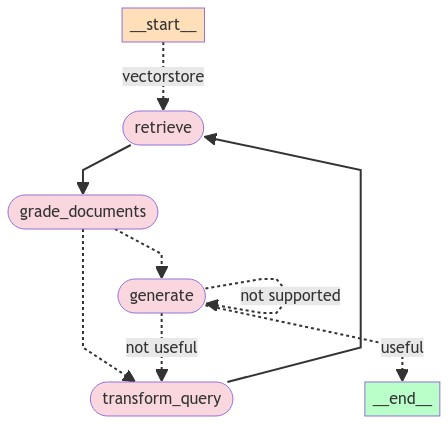

In [30]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [31]:
from pprint import pprint

# Run
inputs = {
    "question": "Cual es el precio de la actyon torres tg 2025?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
datasource='informacion_general'
---ROUTE QUESTION TO INFORMACION_GENERAL---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
"Node 'generate':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
"Node 'generate':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
"Node 'generate':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
"Node 'generate':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DEC

KeyboardInterrupt: 